In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from osgeo import ogr, osr
import fiona
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.10'

The example is from here: https://github.com/gboeing/osmnx-examples/blob/master/notebooks/13-isolines-isochrones.ipynb

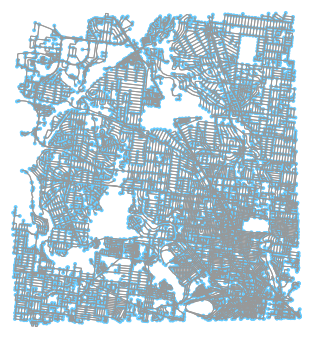

(<Figure size 385.209x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a315710da0>)

In [2]:
# the area - ignore for now
#G = ox.graph_from_bbox(-37.70, -37.795, 144.949, 144.84, network_type='walk')
#G_projected = ox.project_graph(G)
#ox.plot_graph(G_projected)

In [54]:
# configure the place, network type, trip times, and travel speed
place = 'Moonee Ponds, Victoria, Australia'
network_type = 'walk'
trip_times = [5, 10] #in minutes
travel_speed = 4.8 #walking speed in km/hour


# download the street network
G = ox.graph_from_place(place, network_type=network_type)

# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(G, (y[0], x[0]))
G = ox.project_graph(G)

# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [55]:
# get one color for each isochrone
iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)

# isochrone function
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lines.append(LineString([f,t]))

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

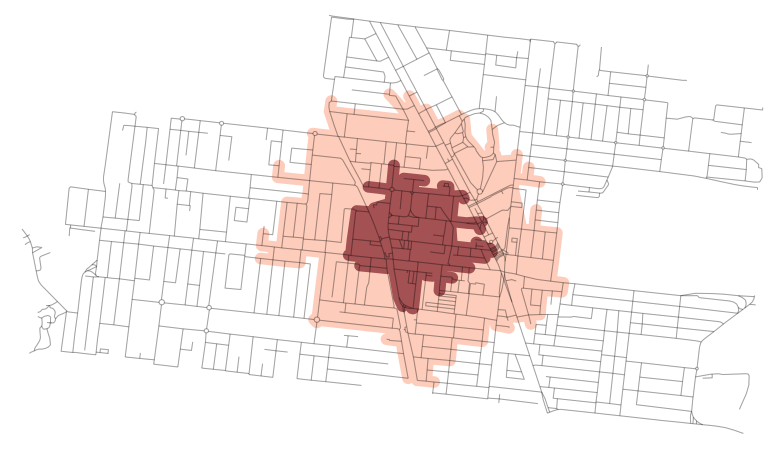

In [56]:
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

In [57]:
isochrone_polys

In [58]:
for i in isochrone_polys:
    mins = 5
    print(i.area)

1023803.8440600553
234817.8212501057


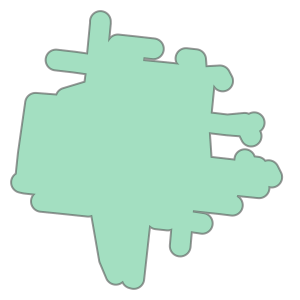

In [59]:
# 400m - 5 minutes
isochrone_polys[1]

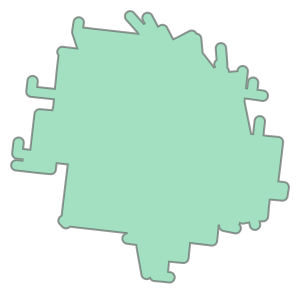

In [60]:
# 800m - 10 minutes
isochrone_polys[0]

In [61]:
#this works but no crs
# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

# Write a new Shapefile
with fiona.open('my_shp2.shp', 'w', 'ESRI Shapefile', schema) as c: #crs = 'epsg:28355' deleted
    ## If there are multiple geometries, put the "for" loop here
    c.write({
        'geometry': mapping(isochrone_polys[1]),
        'properties': {'id': 123},
    })

NameError: name 'mapping' is not defined

In [62]:
type(isochrone_polys[0])

shapely.geometry.polygon.Polygon

In [63]:
# Retrieve only edges from the graph
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Check columns
print(edges.columns)

# Check crs
print(edges.crs)

Index(['access', 'bridge', 'geometry', 'highway', 'junction', 'key', 'lanes',
       'length', 'maxspeed', 'name', 'oneway', 'osmid', 'ref', 'service',
       'time', 'tunnel', 'u', 'v', 'width'],
      dtype='object')
+proj=utm +zone=55 +ellps=WGS84 +datum=WGS84 +units=m +no_defs


In [64]:
from pyproj import Proj, transform
import fiona
from fiona.crs import from_epsg
Proj(isochrone_polys[0].crs)

AttributeError: 'Polygon' object has no attribute 'crs'

In [65]:
isochrone_polys['geometry']['coordinates']

TypeError: list indices must be integers or slices, not str

In [66]:
isochrone_polys[0].bounds

(316180.5323058479,
 -4182509.3153314264,
 317505.03554583143,
 -4181214.9721103134)

In [67]:
oriproj = Proj(isochrone_polys[0].crs, preserve_units=True)

AttributeError: 'Polygon' object has no attribute 'crs'

In [68]:
isochrone_polys[0].geometry

AttributeError: 'Polygon' object has no attribute 'geometry'

In [69]:
oriproj = Proj(isochrone_polys[0].crs, preserve_units=True)

AttributeError: 'Polygon' object has no attribute 'crs'

In [70]:
sr = osr.SpatialReference()
sr.ImportFromEPSG(4326)
driver = ogr.GetDriverByName('ESRI Shapefile')
ds = driver.CreateDataSource('abc.shp')
lyr = ds.CreateLayer('route', sr, ogr.wkbPolygon)

# Make a geometry, from Shapely object
geom = ogr.CreateGeometryFromWkb(isochrone_polys[0].wkb)
feat.SetGeometry(geom)

layer.CreateFeature(feat)
feat = geom = None  # destroy these

# Save and close everything
ds = layer = feat = geom = None


AttributeError: 'NoneType' object has no attribute 'SetGeometry'

In [71]:
# Make a geometry, from Shapely object
geom = ogr.CreateGeometryFromWkb(isochrone_polys[0].wkb)
feat.SetGeometry(geom)

AttributeError: 'NoneType' object has no attribute 'SetGeometry'

In [72]:
from osgeo import osr, ogr # import osr, ogr 
sr = osr.SpatialReference()
sr.ImportFromEPSG(4326)
driver = ogr.GetDriverByName('ESRI Shapefile')
ds = driver.CreateDataSource(isochrone_polys[0])
lyr = ds.CreateLayer('poly', sr, ogr.wkbPolygon)

RuntimeError: not a string

In [73]:
from osgeo import ogr, osr
from shapely.geometry import Polygon

isochrone_polys[0]

# Now convert it to a shapefile with OGR    
sr = osr.SpatialReference()
sr.ImportFromEPSG(4326)
driver = ogr.GetDriverByName('ESRI Shapefile')
ds = driver.CreateDataSource('abc.shp')
layer = ds.CreateLayer('route', sr, ogr.wkbPolygon)# Add one attribute
layer.CreateField(ogr.FieldDefn('id', ogr.OFTInteger))
defn = layer.GetLayerDefn()

## If there are multiple geometries, put the "for" loop here

# Create a new feature (attribute and geometry)
feat = ogr.Feature(defn)
feat.SetField('id', 123)

# Make a geometry, from Shapely object
geom = ogr.CreateGeometryFromWkb(isochrone_polys[0].wkb)
feat.SetGeometry(geom)

layer.CreateFeature(feat)
feat = geom = None  # destroy these

# Save and close everything
ds = layer = feat = geom = None

AttributeError: 'NoneType' object has no attribute 'CreateLayer'